In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib import rc,rcParams
from aacgmv2 import convert
from scipy.interpolate import interp1d 
from scipy.integrate import quad
rc('text', usetex=False)
rcParams['ytick.labelsize'],rcParams['xtick.labelsize'] = 17.,17.
rcParams['axes.labelsize']=19.
rcParams['legend.fontsize']=17.
rcParams['text.latex.preamble'] = ['\\usepackage{siunitx}']
rcParams['figure.figsize'] = (11., 6)

In [2]:
!wget 'http://legacy-www.swpc.noaa.gov/wingkp/wingkp_list.txt' -P Data/ 
!wget 'http://services.swpc.noaa.gov/text/aurora-nowcast-map.txt' -P Data/ 
!wget 'http://services.swpc.noaa.gov/text/goes-particle-flux-primary.txt' -P Data/

--2017-05-05 15:25:45--  http://legacy-www.swpc.noaa.gov/wingkp/wingkp_list.txt
Resolving legacy-www.swpc.noaa.gov (legacy-www.swpc.noaa.gov)... 129.15.96.11, 216.38.80.71, 140.90.33.21, ...
Connecting to legacy-www.swpc.noaa.gov (legacy-www.swpc.noaa.gov)|129.15.96.11|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 77628 (76K) [text/plain]
Saving to: ‘Data/wingkp_list.txt.1’

wingkp_list.txt.1   100%[===================>]  75,81K   189KB/s    in 0,4s    

2017-05-05 15:25:47 (189 KB/s) - ‘Data/wingkp_list.txt.1’ saved [77628/77628]

--2017-05-05 15:25:47--  http://services.swpc.noaa.gov/text/aurora-nowcast-map.txt
Resolving services.swpc.noaa.gov (services.swpc.noaa.gov)... 140.90.33.21, 129.15.96.11, 216.38.80.81, ...
Connecting to services.swpc.noaa.gov (services.swpc.noaa.gov)|140.90.33.21|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2098423 (2,0M) [text/plain]
Saving to: ‘Data/aurora-nowcast-map.txt.1’

aurora-nowcast-map. 100%[

In [3]:
kpl=np.loadtxt('Data/wingkp_list.txt',comments=[':','#'])
aurora=np.loadtxt('Data/aurora-nowcast-map.txt')
flight=np.loadtxt('Data/BIKF-NZAA.csv',delimiter=',',dtype=str)
fluxdata=np.loadtxt('Data/goes-particle-flux-primary.txt',comments=[':','#'])
flat=flight[:,3].astype(float)
flon=flight[:,4].astype(float)
Kphi=[66.5,64.5,62.4,60.4,58.3,56.3,54.2,52.2,50.1,48.1]
kp=kpl[:,17][0]
maxphi=Kphi[int(kp)]
alt=13.

## Συνάρτηση ύψους (ελλειψοειδες)
$$
H(\lambda,\phi)=\frac{ab}{(a\cos \lambda)^2+(b\sin \lambda)^2}
$$

In [8]:
def H(lon,lat,zone='ion'):
    D={'tropo':[20.,7.],'strato':[50.,17.5],'meso':[85.,29.7],'ion':[100.,35.]}
    a=D[zone]
    return a[0]*a[1]/np.sqrt((a[1]*np.cos(lat*np.pi/180.))**2+(a[0]*np.sin(lat*np.pi/180.))**2)

In [9]:
def rho(h): return 0.0014444*np.exp(-0.0001294*h) #density(g/cm^3) on height h(m) 

In [10]:
nlats = 256
nlons = 256
lats=np.linspace(-90,90,nlats)
lons=np.linspace(-180,180,nlons)
glatN=maxphi*np.ones(nlats)
glonN=np.linspace(-180,180,nlons)
mlatN,mlonN=convert(glatN,glonN,alt)
glatS=-maxphi*np.ones(nlats)
glonS=np.linspace(-180,180,nlons)
mlatS,mlonS=convert(glatS,glonS,alt)

In [11]:
p=0.042 #probabillity (GOES data)
f1=fluxdata[:,12][0]*p #Electron Flux >0.8 Mev
f2=fluxdata[:,13][0]*p #Electron Flux >2 Mev
f3=fluxdata[:,14][0]*p if fluxdata[:,14][0]>0. else 0. #Electron Flux >4 Mev

In [12]:
def distance(lon1,lat1,lon2,lat2):
    df=(lat2-lat1)*0.0174533
    phi1=lat1*0.0174533
    phi2=lat2*0.0174533
    dl=(lon2-lon1)*0.0174533
    a=np.sin(df/2.)*np.sin(df/2)+np.cos(phi1)*np.cos(phi2)*np.sin(dl/2)*np.sin(dl/2.)
    c=2.*np.arctan2(np.sqrt(a),np.sqrt(1.-a))
    d = 6371. * c
    return d

In [13]:
def F1(lon,lat,F10,alt=13.,S1=1.680):
    energy0=1.5*2.*F10
    return energy0-S1*quad(rho,alt*1000.,H(lon,lat)*1000.)[0]
def F2(lon,lat,F20,alt=13.,S2=1.783):
    energy0=3.*2.*F20
    return energy0-S2*quad(rho,alt*1000.,H(lon,lat)*1000.)[0]
def F3(lon,lat,F30,alt=13.,S3=1.85):
    energy0=3.*2.*F30
    return energy0-S3*quad(rho,alt*1000.,H(lon,lat)*1000.)[0]
def Fcr(lon,lat,alt=13.):
    return (1.2e3)*(1e-4)*10**((10./3) *np.log10(alt)-1./3) #MeV/cm^2

In [14]:
def Dose(lon,lat,F10,F20,F30,alt=13.):
    K=1.602e-10 #Sv
    S1=0.02706*(F1(lon,lat,F10)/F10)+1.839
    S2=0.02706*(F2(lon,lat,F20)/F20)+1.839
    S3=0.02706*(F3(lon,lat,F30)/F30)+1.839 if F30>0. else 0.
    Scr=0.03908*np.exp(0.006463*Fcr(lon,lat,alt)/Fcr(lon,lat,100))+0.002216
    final1=F1(lon,lat,F10)-2322. if F1(lon,lat,F10)>2322. else 0.
    final2=F2(lon,lat,F20)-2322. if F2(lon,lat,F20)>2322. else 0.
    final3=F3(lon,lat,F30)-2322. if F3(lon,lat,F30)>2322. else 0.
    finalcr=Fcr(lon,lat,alt) - 50.139 if Fcr(lon,lat,alt)>50.139 else 0.
    return K*2.*np.pi*(S1*final1+S2*final2+S3*final3+Scr*finalcr)

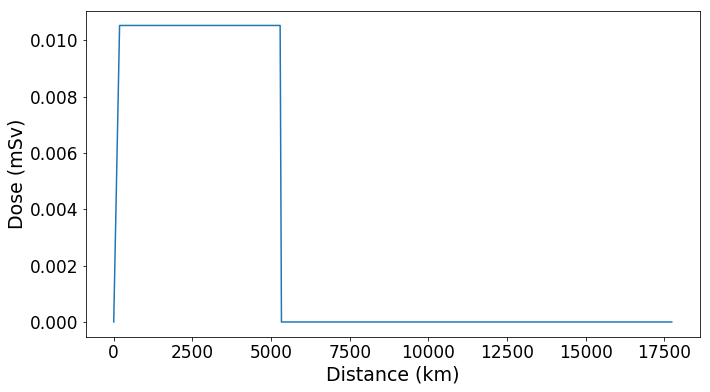

In [15]:
#prob= np.array([F1(flon[i],flat[i],f1) if convert(flat[i],flon[i],alt)>convert(maxphi,flon[i],alt) else 0. for i in range(flon.shape[0])])
prob=(1e3)*np.array([Dose(flon[i],flat[i],f1,f2,f3) if convert(flat[i],flon[i],alt)>convert(maxphi,flon[i],alt) else 0. for i in range(flon.shape[0])])
dist=np.array([distance(flon[i-1],flat[i-1],flon[i],flat[i]) for i in range(1,flon.shape[0])])
dist=np.cumsum(np.insert(dist,0,0))
rad=interp1d(dist,prob)
plt.plot(dist,rad(dist))
plt.ylabel('Dose (mSv)')
plt.xlabel('Distance (km)')
plt.savefig('ExportedImages/Dose.png')

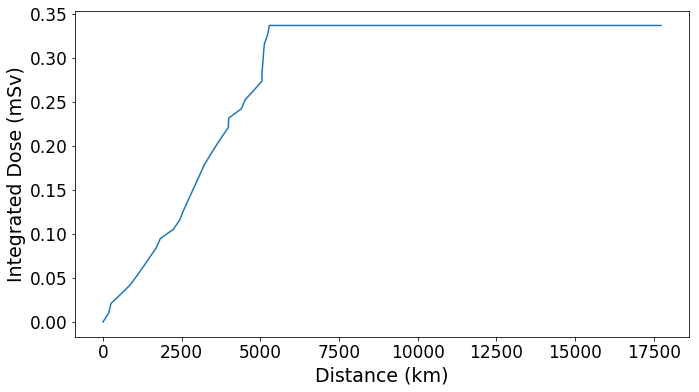

In [16]:
plt.plot(dist,np.cumsum(rad(dist)))
plt.ylabel('Integrated Dose (mSv)')
plt.xlabel('Distance (km)')
plt.savefig('ExportedImages/integratedDose.png')

In [17]:
DoseMap=np.array([[Dose(x,y,f1,f2,f3) for x in lons[::1]] for y in lats[::1]])

In [18]:
Data=np.zeros((dist.shape[0],5))
Data[:,0]=flon
Data[:,1]=flat
Data[:,2]=dist
Data[:,3]=rad(dist)
Data[:,4]=np.cumsum(rad(dist)) 
np.savetxt('Data/data.csv',Data,header='Lon,Lat,Distance,Radiance,CummulativeRadiance',delimiter=',',comments='')

                Geostationary, Orthographic or Azimuthal equidistant basemap
                

/usr/lib/python2.7/dist-packages/mpl_toolkits/basemap/__init__.py:3608: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/usr/lib/python2.7/dist-packages/mpl_toolkits/basemap/__init__.py:3677: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/usr/lib/python2.7/dist-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/usr/lib/python2.7/dist-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


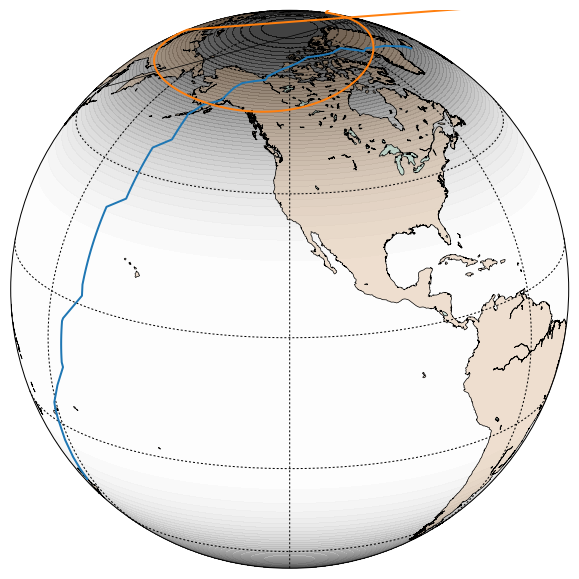

In [21]:
X,Y=np.meshgrid(lons,lats)
fig=plt.figure(figsize=(10,20))
m = Basemap(projection='ortho',lat_0=20,lon_0=-120,resolution='l')
m.drawcoastlines(linewidth=0.7)
m.fillcontinents(color='#cc9966',lake_color='#99ffff',alpha=0.3)
m.drawparallels(np.arange(-80,81,30),labels=[1,1,0,0])
#m.drawparallels([maxphi,-maxphi],labels=[1,1,0,0])
m.drawmeridians(np.arange(0,360,60),labels=[0,0,0,1])
#M=Dose(X,Y,f1,f2,f3)
cm=m.contourf(X,Y,DoseMap,latlon=True,alpha=0.75,cmap='gist_gray_r',levels=np.linspace(DoseMap.min(),DoseMap.max()))
#plt.colorbar(cm)
m.plot(flon,flat,latlon=True,linewidth=2.)
m.plot(m.shiftdata(mlonN, mlatN)[0],m.shiftdata(mlonN, mlatN)[1],latlon=True,linewidth=2)
m.plot(m.shiftdata(mlonS, mlatS)[0],m.shiftdata(mlonS, mlatS)[1],latlon=True,linewidth=2)
fig.savefig('ExportedImages/DosePlanet.png')